In [1]:
# assume working in Jupyter Lab
%matplotlib notebook 

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../pywed')
sys.path.append('../IRFMtb')

import pywed as pw
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (10,6)

from control_room import *
from pulse_database import PulseDB

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

from scipy.optimize import curve_fit 
from tqdm import tqdm

IMAS only available on linux machines


# Importing the database

In [3]:
# Importing Resumed Parameters
data = pd.read_csv('WEST_C4_database_resumed_parameters_2.csv')
data.head()

,Unnamed: 0,IC_Frequencies,IC_P_Q1,IC_P_Q2,IC_P_Q4,IC_P_tot,IC_Rc_Q1_avg,IC_Rc_Q2_avg,IC_Rc_Q4_avg,IC_Voltage_left_lower_Q1,...,R_Q1,R_Q2,R_Q4,Rext_median,Separatrix_P,freq_Q1,freq_Q2,freq_Q4,nl,pulse
0,0,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,1.249,...,3.0109,3.0111,3.0118,2992.12,2.068885,55.5,55.689999,55.700001,0.677500,54404
1,1,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,1.249,...,3.0109,3.0111,3.0118,2993.92,0.797955,55.5,55.689999,55.700001,0.964195,54404
2,2,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,1.249,...,3.0109,3.0111,3.0118,2947.24,-0.231872,55.5,55.689999,55.700001,1.185943,54404
3,3,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,1.249,...,3.0109,3.0111,3.0118,2889.28,0.209434,55.5,55.689999,55.700001,1.191996,54404
4,4,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,1.249,...,3.0109,3.0111,3.0118,2909.92,0.545797,55.5,55.689999,55.700001,1.199769,54404


# Derived quantities

In [4]:
data['Ptot'] = data['Ohmic_P'] + data['LH_P_tot'] + data['IC_P_tot']/1e3
data['P_conv'] = data['Ptot'] - data['Prad']
data['frad'] = data['Prad']/data['Ptot']
data['frad_bulk'] = data['Prad_bulk']/data['Ptot']

In [5]:
data['ROG_LH'] = data['LH_Positions']*1e3 - data['Rext_median']
data['ROG_Q1'] = data['R_Q1']*1e3 - data['Rext_median']
data['ROG_Q2'] = data['R_Q2']*1e3 - data['Rext_median']
data['ROG_Q4'] = data['R_Q4']*1e3 - data['Rext_median']


In [6]:
data['P_conv_ratio'] = data['P_conv']/(data['IC_P_tot']*1e-3)

In [7]:
data.query('IC_P_tot > 500 and P_conv > 0.5')['P_conv'].min()

0.5000860722087828

# Max Powers

In [17]:
test = data.query('IC_P_tot > 100 or LH_P_tot > 0.2').groupby('pulse').max()

In [18]:
test['pulse'] = test.index
test['P_IC'] = test['IC_P_tot']/1e3

<IPython.core.display.Javascript object>


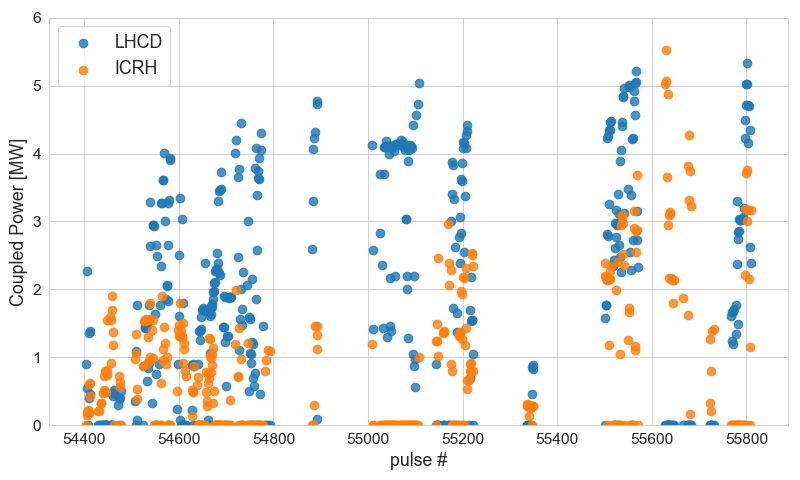

In [28]:
fig, ax = plt.subplots()
test.plot(kind='scatter', x='pulse', y='LH_P_tot', s=60, ax=ax, c='C0', alpha=.8, label='LHCD')
test.plot(kind='scatter', x='pulse', y='P_IC', s=60, ax=ax, c='C1', alpha=.8, label='ICRH')

ax.set_xlabel('pulse #', fontsize=16)
ax.set_ylabel('Coupled Power [MW]', fontsize=16)
ax.tick_params(labelsize=14)
ax.set_ylim(0,6)
ax.legend(fontsize=16)
fig.tight_layout()

fig.savefig('WEST_C4_LHCD_ICRH_max_power.png', dpi=150)

# Link between radiated power and LCFS radius

<IPython.core.display.Javascript object>


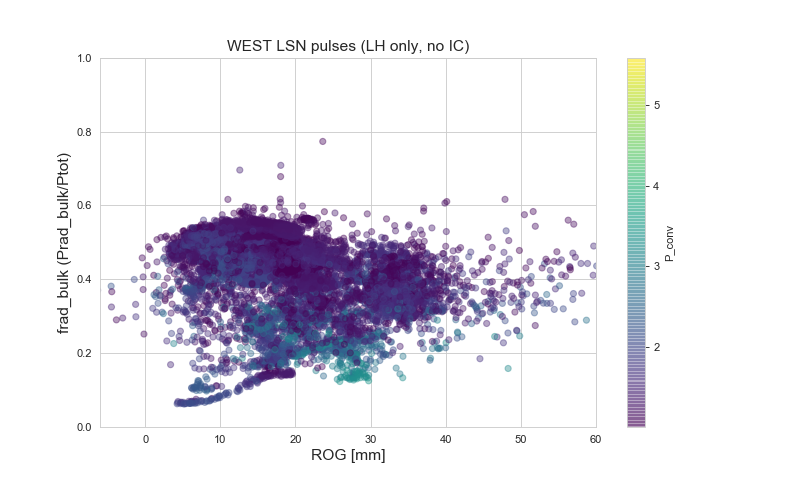

Text(0.5, 1.0, 'WEST LSN pulses (LH only, no IC)')

In [193]:
fig, ax = plt.subplots()
data.query('IC_P_tot < 50 and LH_P_tot > 0.5 and P_conv > 1 and frad > 0.05').\
    plot(kind='scatter', x='ROG_LH', y='frad_bulk', ax=ax,
    c='P_conv', cmap='viridis', alpha=0.4, s=30)
ax.set_xlim(left=-6,right=60)
ax.set_ylim(0, 1)
ax.set_xlabel('ROG [mm]', fontsize=14)
ax.set_ylabel('frad_bulk (Prad_bulk/Ptot)', fontsize=14)
ax.set_title('WEST LSN pulses (LH only, no IC)', fontsize=14)